In [ ]:
import darts 
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import warnings
import optuna
import scipy

from darts.dataprocessing.transformers import Scaler
from darts.models.filtering.gaussian_process_filter import GaussianProcessFilter
from darts.models.filtering.kalman_filter import KalmanFilter
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.metrics import mae, mse, smape

from darts.models.forecasting.nhits import NHiTSModel
from darts.models.forecasting.nbeats import NBEATSModel
from darts.models.forecasting.transformer_model import TransformerModel

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
warnings.filterwarnings('ignore')
plt.style.use('default')

%matplotlib inline

In [ ]:
Fs = 1000 # Sample rate
t  = np.linspace(0, 0.25, Fs, False) # Time
f  = 20 # Frequency in Hz
signal = np.sin(2 * np.pi * f * t)

plt.figure(figsize = (8,2))
plt.title(f'{f} Hz Sinusoid')
plt.plot(t, signal)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
noise = np.random.normal(0, 1, size=len(t))

plt.figure(figsize=(8,2))
plt.title('Gaussian Noise')
plt.plot(t, noise)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
plt.figure(figsize= (6,4))
plt.title('Noise distribution')
plt.hist(noise, bins=15, color='lightgreen', ec='black')

In [ ]:
noised_signal = signal + noise

plt.figure(figsize=(8,2))
plt.title('Noised Signal')
plt.plot(t, noised_signal)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
pd.plotting.autocorrelation_plot(pd.Series(noised_signal))

In [ ]:
noised_signal = darts.TimeSeries.from_values(noised_signal)
scaled_signal = Scaler().fit_transform(noised_signal)

In [ ]:
train_size = int(0.6 * len(scaled_signal))
train_samples, test_samples = scaled_signal[: train_size], scaled_signal[train_size: ]

In [ ]:
train_samples.plot(label='train samples')
test_samples.plot(label='test samples')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
if torch.cuda.is_available():
    pl_trainer_kwargs = {'accelerator'      : 'gpu',
                         'devices'          : -1,
                         'auto_select_gpus' : True}
else:
    pl_trainer_kwargs = {'accelerator' : 'cpu'}

In [ ]:
input_size  = len(scaled_signal) // 4
output_size = len(scaled_signal) // 8
batch_size  = 256
epochs      = 20
dropout     = .2
lr          = 1e-3

In [ ]:
models = [NBEATSModel(input_chunk_length = input_size,
                      output_chunk_length = output_size,
                      batch_size = batch_size,
                      dropout = dropout,
                      optimizer_kwargs = {'lr' : lr},
                      generic_architecture = True,
                      pl_trainer_kwargs = pl_trainer_kwargs),
        
        NHiTSModel(input_chunk_length = input_size,
                   output_chunk_length = output_size,
                   batch_size = batch_size,
                   dropout = dropout,
                   optimizer_kwargs = {'lr' : lr},
                   pl_trainer_kwargs = pl_trainer_kwargs), 
         
         #TransformerModel(input_chunk_length = input_size,
         #                  output_chunk_length = output_size,
         #                  batch_size = batch_size,
         #                  dropout = dropout,
         #                  optimizer_kwargs = {'lr' : lr},
         #                  d_model = 64,
         #                  nhead = 4,
         #                  pl_trainer_kwargs = pl_trainer_kwargs)
         ]

models_label = ['NHITS', 'NBEATs']

def forecasting(list_of_models, train_samples, test_samples):
    forecast = []
    for model in list_of_models:
        model.fit(series = train_samples, epochs = epochs)
        forecast.append(model.predict(n = len(test_samples)))
    return forecast

In [ ]:
results = forecasting(models, train_samples, test_samples)

In [ ]:
def plot_results(results, labels):
    plt.figure(figsize = (8,4))
    test_samples.plot(label = 'Actual', color='b')
    for idx, predicted in enumerate(results):
        predicted.plot(label=labels[idx])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Forecasted')

plot_results(results, models_label)

In [ ]:
original_signal = darts.TimeSeries.from_values(signal)[train_size: ]
original_signal = Scaler().fit_transform(original_signal)

filters = [GaussianProcessFilter(), KalmanFilter(dim_x=2).fit(original_signal), MovingAverageFilter(window=10)]
labels = ['Gaussian', 'Kalman', 'MovingAverage']

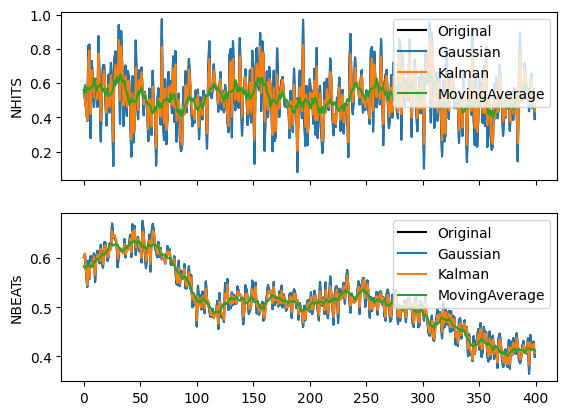

In [105]:
fig, ax = plt.subplots(nrows=len(models), ncols=1, sharex=True)
for idx, forecast in enumerate(results):
    ax[idx].plot(darts.TimeSeries.all_values(forecast).flatten(), label='Original', color='black')
    for id, filter in enumerate(filters):
        filted = filter.filter(forecast)
        filted = darts.TimeSeries.all_values(filted)
        ax[idx].plot(filted.flatten(), label=labels[id])
        ax[idx].set_ylabel(models_label[idx])
        ax[idx].legend()